<h3 style="text-align:center">
    In the name of God
</h3>
<p style="text-align:left">
    Machine Learning Course 1400, Dr. Sajedi
    <br>HW1
    <br>Alireza Kazemipour
    <br>610300171
</p>

### Importing packages
Here we import python packages that are going to be used over the course of the following code:
- *SVC* is the package for performing Support Vector Machine classifier.
- *DecisionTreeClassifier* is the package for performing Decision Tree classifier.
- *RandomForestClassifier* is the package for performing Random Forest classifier.
- *XGBClassifier* is the package for performing XGBoost classifier.
- *confusion_matrix* and *classification_report* willbe used to report training and testing metrics.
- *pandas* is the package for working with structured `.csv` files.
- *matplotlib* is the package for drawing plots.
- *seaborn* is the package for drawing attractive and informative statistical graphics.
- *tqdm* is the package for displaying progress bars.
- *numpy* is the package provided for numerical, algerbric, and etc operations.

In [2]:
%matplotlib inline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import warnings

warnings.filterwarnings("ignore")

### Importing the dataset
The dataset was provided with a text file such that it represented a matrix whose rows were specified by the lines of the file and its rows were separated by `,`s. Thus, we read the matrix line by line.

In [3]:
data = []
with open("data.txt", 'r') as f:
    for i, line in enumerate(f):
        str_values = line.split(',')
        float_values = []
        for v in str_values:
            float_values.append(float(v))
        data.append(float_values)

### Preparing input features and labels
The first column of the imported dataset was the subjects' numbers so it was removed as it didn't contain any useful information.  
Last column of the dataset was representing the labels so, they were gathered in our label vector also, their categorical numbers from `[1, 2, ..., number of classes]` changed to `[0, 1, ..., number of classes - 1]` as it was neccesarry for optimization of imported packages.

In [4]:
data = np.stack(data)
X = data[:, 1:-1]
Y = data[:, -1].astype(int) - 1
n_class = np.max(Y) + 1

### Fixing parameters
Here we fix number of *folds* fo the *k-fold Cross Validation* method. Also, we fix the seed of randomness in our work to produce comparable and reproducible results among different runs or algorithms.

In [5]:
cv_num = 5
seed = 123

### Shuffling the dataset
Here we shuffle the dataset to be able to perform *k-fold Cross Validation* method.

In [6]:
np.random.seed(seed)
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

### Train-Test split
Here 10% of the total data that we have is randomly reserved for testing learned models:

In [7]:
test_idx = np.random.permutation(int(0.1 * len(X)))
x_test = X[test_idx]
y_test = Y[test_idx]

X = np.delete(X, test_idx, axis=0)
Y = np.delete(Y, test_idx, axis=0)
full_batch_size = X.shape[0]

### Input standardization
We observed that if we standardize the input (which means making it a *zero mean* with *unit variance* distribution) for various algorithms **especially the SVM** then the training phase is done smoother and higher accuracy is more likely to be reached easily. Why? Because, classifying a *zero-mean*-*unit-variance* data (for example by a line) is less sensitive to changes in paramteres.  
The following picture shows the concept so that the normalized data is less sensitive to the changes in the slope of the line:

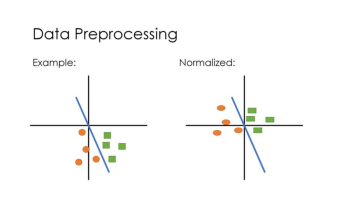

In [15]:
import matplotlib.image as mpimg
img = mpimg.imread('Input_Normalization.png')
plt.imshow(img)
plt.axis("off")
plt.show()

In [7]:
scaler = StandardScaler()  # essential for SVM
X = scaler.fit_transform(X)

### K-Fold Cross Validation
To perform *5-fold cross validation* a python generator has been used such that at each iteration, it picks $\frac{1}{5}$ of data for validation and the remaining for the training. It performs the eplained procedure by sweeping the data devoted for training phase. 

In [8]:
def choose_fold(x, y, n):
    for i in range(n):
        x_val = x[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]
        y_val = y[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]

        x_train = np.delete(x, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)
        y_train = np.delete(y, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)

        yield x_train, y_train, x_val, y_val


### Models' Definition
To realize integrity and demonstrating how each model is trained based on an identical bottomline, we have described all of our classification methods here to use them in the training loop later.  
The logic behind the this part of the code is that each classifier has a base classifier `base_clf` that all the fixed hyperparameters have been set to it and they won't be changed. Secondly, there a `param` attribute which is a hyperparameter that we're seeking its optimal value. Third, there is `param_values` that specifes the range that the search of optimal hyperparameter should be done with it.

#### Now let's take a look at each specific classifier's configuration 
- Linear SVM
1. The *One vs One* strategy is used for the optimization since we're dealing with a multi-class classification and *One vs One* is the choice of preference for this kind of problems.
2. The hyperparameter that we're searching for its optimal value is `C`that is proportional to the inverse of regularizer coefficient. Thus, as it increases the regularization effect decreases.
3. Only two values of {1, 10} was explored since higher values (in logspace) for `C` make the linear SVM get stuck in an infinite otimization loop.
- RBF SVM
1. The radial-basis function was used as the non-linear kernel function to perform non-linear classification.
2. The *One vs One* strategy is used for the optimization.
3. The hyperparameter that we're searching for its optimal value is `C`.
4. Search range: `[1, 10, 100, 1000, 1e+4, 1e+5]`.
- Decision Tree
1. *entropy* criterion was selected for choosing best features during tree's construction
2. Since we would like to avoid *overfitting* the hyperparameter that is being sought is `max_depth`. Because if we could find relatively small values for this hyperparameter the, the tree would be shallow, simple and more capable of generalization due to the fact that a lot of branches have been pruned.
3. Search range for level of the tree's depth: `[1, 2, ..., 20]`
- Random Forest
1. *entropy* criterion was selected for choosing best features during the forest's tree construction
2. `max_depth` of each tree is taken from the `max_depth` that we obtained from *Decision Tree*. (implemented later in the code.)
3. Since we would like to avoid *overfitting* the hyperparameter that is being sought is `n_estimators` aka `n_tree`. Because if we could find relatively small values for this hyperparameter the, the forest would be sparse, simple and more capable of generalization due to the fact that a lot of tree have been chopped.
4. No bootstraping is allowed and the whole dataset is used for each tree as it was observed that bootstrapping hampers the performance.
5. Search range for the number of trees: `[1, 2, ..., 45]` 
- XGBoost
1. `max_depth` of each tree is taken from the `max_depth` that we obtained from *Decision Tree*. (implemented later in the code.)
2. `n_estimators` of the forest is taken from the `n_estimators` that we obtained from *Random Forest*. (implemented later in the code.)
3. The `booster` type was chosen `gbtree` which means individual learners are tree-based
4. The `tree_method` was chosen to be `hist` as it is similar to the `exact` method that greedily enumerates all candidate splits however, `hist` is faster.
5. Regularizer coefficient chosen to be `1e-3`.
6. loss type was chosen `logloss` aka *Categorical Cross Entropy*. (The suitable loos type for multi-class classification.)
7. `learning_rate` was the hyperparameter that we performed search on since, it is the most influencial hyperparameter for *XGBoost*.
8. Search range for the learning rate: `[1, 5e-1, 1e-2, 5e-3]` 

In [15]:
clfs = {"Linear SVM": {"base_clf": SVC(decision_function_shape="ovo",
                                       random_state=seed),
                       "param": "C",
                       "param_values": [1, 10]
                       },
        "RBF-SVM": {"base_clf": SVC(kernel="rbf",
                                    decision_function_shape="ovo",
                                    random_state=seed),
                    "param": "C",
                    "param_values": [1, 10, 100, 1000, 1e+4, 1e+5]
                    },
        "Decision Tree": {"base_clf": DecisionTreeClassifier(criterion="entropy", random_state=seed),
                          "param": "max_depth",
                          "param_values": np.arange(1, 21)
                          },
        "Random Forest": {"base_clf": RandomForestClassifier(criterion="entropy",
                                                             random_state=seed,
                                                             bootstrap=False),
                          "param": "n_estimators",
                          "param_values": np.arange(1, 46)
                          },
        "XGBoost": {"base_clf": XGBClassifier(booster="gbtree",
                                              tree_method="hist",
                                              reg_lambda=1e-3,
                                              random_state=seed,
                                              objective='logloss',
                                              use_label_encoder=True,
                                              verbosity=0),
                    "param": "learning_rate",
                    "param_values": [1, 5e-1, 1e-2, 5e-3]
                    }
        }

### Main Loop
#### Logic:
For every classifier we search over its range of values for the hyperparameter it needs to find. We perform *5-fold cross validation* and the best hyperparameter is the one that its corrrespondig average model during *5-fold cross validation* achieves the highest *validation accuracy*. Then, we report the important training and validation metrics.  
Then, performance metrics on the test data that we put aside in the first place is computed and reported and based on that, the best model found yet is selected. At last, `max_depth` and `n_estimators` of *Decision Tree* and *Random Forest* algorithms are used for further related algorithms such as *XGBoost*.

__It's important to note that the Standardization was fitted on the training data and during test phase we used those values as well.__

100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.91s/it]


==> Linear SVM <==
Training result:
	best param: C = 10
	best validation accuracy = 90.25%


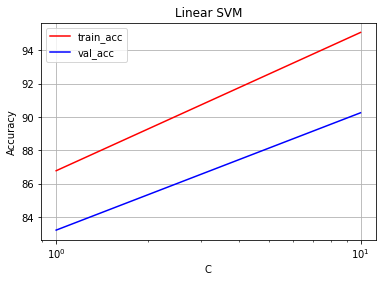

Test result: 


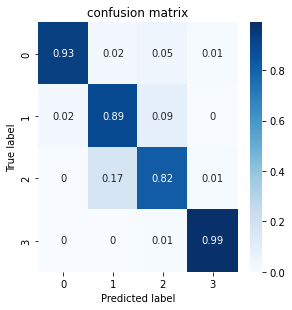

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       107
           1       0.83      0.89      0.86       108
           2       0.84      0.82      0.83       106
           3       0.98      0.99      0.99       127

    accuracy                           0.91       448
   macro avg       0.91      0.91      0.91       448
weighted avg       0.91      0.91      0.91       448



100%|█████████████████████████████████████████████| 6/6 [01:36<00:00, 16.01s/it]


==> RBF-SVM <==
Training result:
	best param: C = 1000
	best validation accuracy = 94.02%


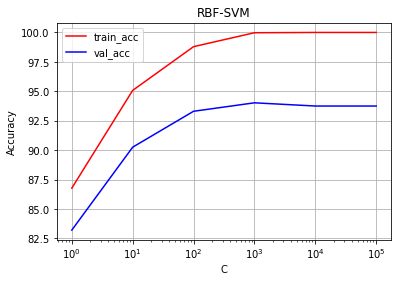

Test result: 


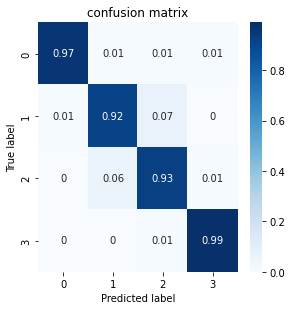

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       107
           1       0.93      0.92      0.93       108
           2       0.91      0.93      0.92       106
           3       0.98      0.99      0.99       127

    accuracy                           0.96       448
   macro avg       0.95      0.95      0.95       448
weighted avg       0.96      0.96      0.96       448



100%|███████████████████████████████████████████| 20/20 [01:54<00:00,  5.73s/it]

==> Decision Tree <==
Training result:
	best param: max_depth = 18
	best validation accuracy = 92.51%


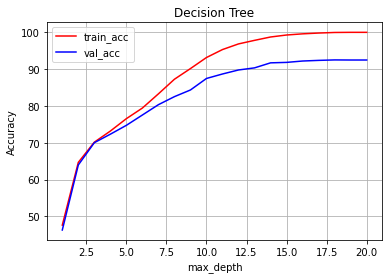

Test result: 


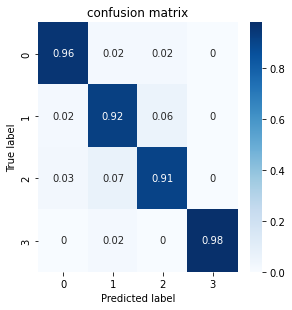

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       107
           1       0.90      0.92      0.91       108
           2       0.91      0.91      0.91       106
           3       1.00      0.98      0.99       127

    accuracy                           0.94       448
   macro avg       0.94      0.94      0.94       448
weighted avg       0.94      0.94      0.94       448



100%|███████████████████████████████████████████| 45/45 [06:11<00:00,  8.26s/it]

==> Random Forest <==
Training result:
	best param: n_estimators = 45
	best validation accuracy = 99.23%


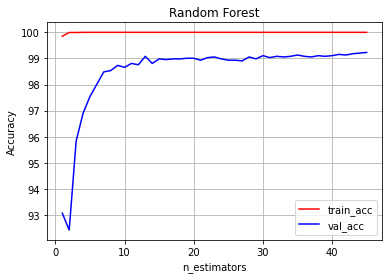

Test result: 


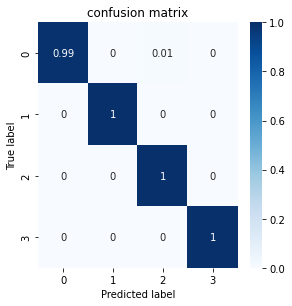

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       107
           1       1.00      1.00      1.00       108
           2       0.99      1.00      1.00       106
           3       1.00      1.00      1.00       127

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



100%|█████████████████████████████████████████████| 4/4 [06:36<00:00, 99.03s/it]


==> XGBoost <==
Training result:
	best param: learning_rate = 0.5
	best validation accuracy = 98.98%


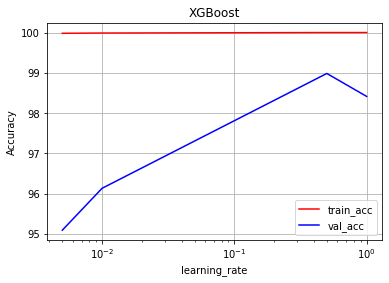

Test result: 


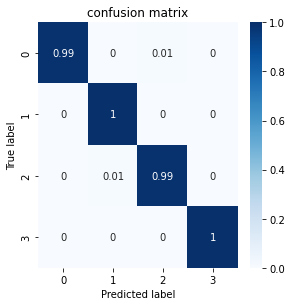

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       107
           1       0.99      1.00      1.00       108
           2       0.99      0.99      0.99       106
           3       1.00      1.00      1.00       127

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448


🎁🎁🎁best_model is: Random Forest with test acc = 99.78%.


In [18]:
best_test_acc = -np.inf
best_model = {}

for clf_name, config in clfs.items():
    history = {"train_acc": [], "val_acc": []}
    best_val_acc = 0
    best_param = None

    for p in tqdm(config["param_values"]):
        avg_val_acc = 0
        avg_train_acc = 0

        for x_train, y_train, x_val, y_val in choose_fold(X, Y, cv_num):
            clf = config["base_clf"]
            setattr(clf, config["param"], p)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_train)
            avg_train_acc += (np.sum(y_pred == y_train) / len(y_pred)) * 100
            y_pred = clf.predict(x_val)
            avg_val_acc += (np.sum(y_pred == y_val) / len(y_pred)) * 100

        history["train_acc"].append(avg_train_acc / cv_num)
        history["val_acc"].append(avg_val_acc / cv_num)

        if history["val_acc"][-1] > best_val_acc:
            best_val_acc = history["val_acc"][-1]
            best_param = p

    print(f"==> {clf_name} <==")
    print("Training result:")
    print("\tbest param: {} = {}\n\tbest validation accuracy = {:.2f}%".format(config["param"],
                                                                               best_param,
                                                                               best_val_acc))
    plt.plot(config["param_values"], history["train_acc"], c="r")
    plt.plot(config["param_values"], history["val_acc"], c="b")
    plt.legend(history.keys())
    plt.grid()
    plt.title(clf_name)
    plt.ylabel("Accuracy")
    plt.xlabel(config["param"])
    if "SVM" in clf_name or clf_name == "XGBoost":
        plt.xscale("log")
    plt.show()
    print("Test result: ")
    setattr(clf, config["param"], best_param)
    clf.fit(X, Y)
    x_test_stand = scaler.transform(x_test)
    y_pred = clf.predict(x_test_stand)
    test_acc = (np.sum(y_pred == y_test) / len(y_pred)) * 100
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model["name"] = clf_name
        best_model["clf"] = clf
    con_mat = confusion_matrix(y_test, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
    figure = plt.figure(figsize=(n_class, n_class))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    report = classification_report(y_test, y_pred)
    print(report)

    if clf_name == "Decision Tree":
        setattr(clfs["Random Forest"]["base_clf"], "max_depth", best_param)
        setattr(clfs["XGBoost"]["base_clf"], "max_depth", best_param)

    if clf_name == "Random Forest":
        setattr(clfs["XGBoost"]["base_clf"], "n_estimators", best_param)
        
print(f"\n🎁🎁🎁best_model is: {best_model['name']} with test acc = {best_test_acc:.2f}%.")

### Best model
Since the dataset is quite __balanced__, the *accuracy* metric on the test set can be good measure for choosing the best model therefore, the best model is Random forest wth accuracy = 99.78%

### Metrics and confusion matrix for the best model

test accuracy = 99.78


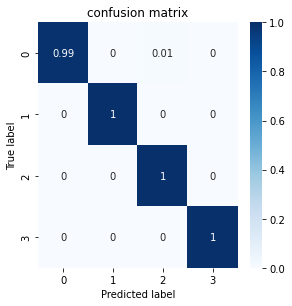

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       107
           1       1.00      1.00      1.00       108
           2       0.99      1.00      1.00       106
           3       1.00      1.00      1.00       127

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



In [23]:
clf = best_model["clf"]
clf.fit(X, Y)
x_test_stand = scaler.transform(x_test)
y_pred = clf.predict(x_test_stand)
test_acc = (np.sum(y_pred == y_test) / len(y_pred)) * 100
print(f"test accuracy = {test_acc:.2f}")
con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
figure = plt.figure(figsize=(n_class, n_class))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('confusion matrix')
plt.show()
report = classification_report(y_test, y_pred)
print(report)

### Table of resutls
|   Method   | Value of Parameters   | Accuracy   | Precision |   Recall  |  F-measure |    
| :--------: | :-------------------: |:----------:|:---------:| :-------: | :--------: |
| Linear SVM |         C=10          |  0.91      |  0.91     |     0.91  |    0.91    |
| RBF SVM    |         C=1000        |  0.96      |  0.96     |     0.96  |    0.96    |
| Decision Tree|       max_depth=18  |  0.94      |  0.94     |     0.94  |    0.94    |
| Random Forest|   n_estimators=45   |  1.0       |  1.0      |     1.0   |    1.0     |
| XGBoost      |   learning_rate=0.5 |  1.0       |  1.0      |     1.0   |    1.0     |